In [1]:
import numpy as np
from scipy.special import expit  # sigmoid

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
x_train = x_train.reshape(x_train.shape[0], -1)  # flatten

In [3]:
class RBM:
    def __init__(self, n_visible, n_hidden):
        self.W = np.random.randn(n_visible, n_hidden) * 0.1  # Weights
        self.v_bias = np.zeros(n_visible)  # Visible layer bias
        self.h_bias = np.zeros(n_hidden)  # Hidden layer bias

        # Grads
        self.W_grad = np.zeros(self.W.shape)
        self.vbias_grad = np.zeros(n_visible)
        self.hbias_grad = np.zeros(n_hidden)

        self.n_hidden = n_hidden
        self.n_visible = n_visible

    def sigmoid(self, x):
        # return 1 / (1 + np.exp(-x))
        return expit(x)

    def sample_h_given_v(self, v):
        p = self.sigmoid(np.dot(v, self.W) + self.h_bias) # p(H | v)
        h1_sample = np.random.binomial(1, p) # samples from p(H | v)
        return p, h1_sample

    def sample_v_given_h(self, h):
        p = self.sigmoid(np.dot(h, self.W.T) + self.v_bias)  # p(V | h)
        v1_sample = np.random.binomial(1, p)  # samples from p(V | h)
        return p, v1_sample

    def reconstruct(self, v):
        ph0, h0 = self.sample_h_given_v(v)
        pv1, v1 = self.sample_v_given_h(ph0)
        return pv1
        
    def train(self, batch, learning_rate=0.5):

        batch_size = batch.shape[0]
        v0_sample = batch.reshape(batch_size, -1)

        # Positive phase
        h0_mean, h0_sample = self.sample_h_given_v(v0_sample)
        W_grad = np.dot(v0_sample.T, h0_mean)
        vbias_grad = np.sum(v0_sample, axis=0)
        hbias_grad = np.sum(h0_mean, axis=0)

        # Negative phase
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)

        W_grad -= np.dot(v1_mean.T, h1_mean)
        vbias_grad = vbias_grad.astype(np.float64) - np.sum(v1_mean, axis=0).astype(np.float64)
        hbias_grad = hbias_grad.astype(np.float64) - np.sum(h1_mean, axis=0).astype(np.float64)

        self.W_grad = W_grad / batch_size
        self.hbias_grad = hbias_grad / batch_size
        self.vbias_grad = vbias_grad / batch_size

        # Update parameters
        self.W += learning_rate * self.W_grad
        self.v_bias += learning_rate * self.vbias_grad
        self.h_bias += learning_rate * self.hbias_grad


        error = np.mean(
            np.sum((v0_sample - v1_mean) ** 2, axis=1), axis=0
        )  # sum of squared error averaged over the batch

        return error

In [4]:
rbm = RBM(784, 100)


selected_imgs = x_train[[1, 6, 5, 12, 26, 35, 62, 52, 46, 4]]

def get_batches(data, batch_size):
    assert batch_size > 0 and batch_size <= len(data)
    num_batches = math.ceil(data.shape[0] / batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num * batch_size : (batch_num + 1) * batch_size]

In [5]:
from time import time
import math

start_time = time()

for i in range(10): # epochs
    training_error = 0
    for batch in get_batches(x_train, batch_size=50):
        training_error += rbm.train(batch)

    print("Training error: ", training_error, " | ",  "Training time: ", time() - start_time)

Training error:  26831.75719059894  |  Training time:  9.39152216911316
Training error:  20635.798843798908  |  Training time:  17.869680166244507
Training error:  19255.591175086072  |  Training time:  25.36793804168701
Training error:  18668.00451995719  |  Training time:  32.487967014312744
Training error:  18295.073209951122  |  Training time:  39.54586124420166
Training error:  18105.601291144518  |  Training time:  46.51612424850464
Training error:  17981.325964303214  |  Training time:  53.278454065322876
Training error:  17851.827191657536  |  Training time:  60.148078203201294
Training error:  17749.638744873395  |  Training time:  68.96629524230957
Training error:  17711.673054445913  |  Training time:  76.23609113693237


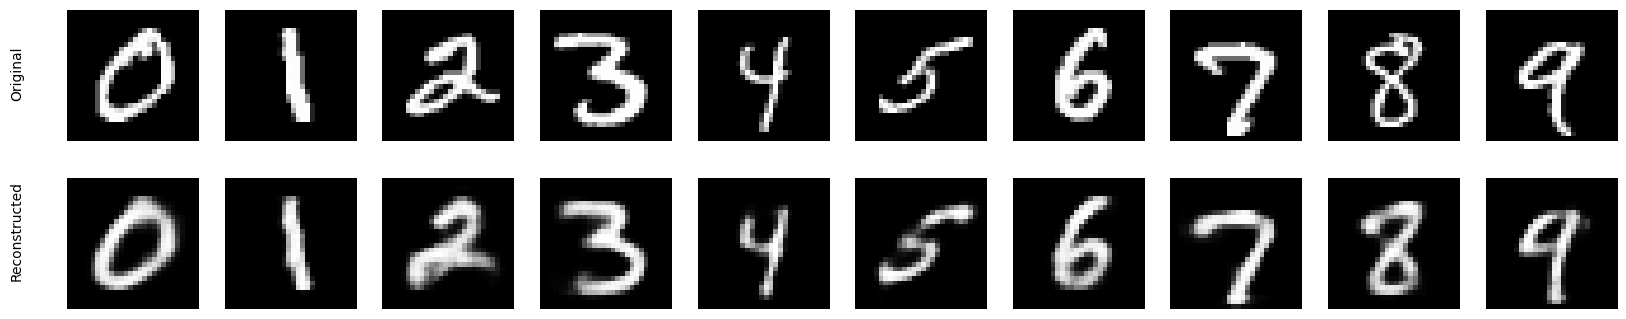

In [6]:
import matplotlib.pyplot as plt

def plot_images(rbm, images):
    num_images = len(images)
    plt.figure(figsize=(2 * num_images, 4))

    for i, image in enumerate(images):
        # Plot original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Plot reconstructed images
        plt.subplot(2, num_images, num_images + i + 1)
        reconstructed_image = rbm.reconstruct(image.reshape(28 * 28)).reshape(28, 28)
        plt.imshow(reconstructed_image, cmap="gray")
        plt.axis("off")

    plt.figtext(0.1, 0.65, "Original", ha="center", rotation="vertical")
    plt.figtext(0.1, 0.20, "Reconstructed", ha="center", rotation="vertical")

    plt.show()

plot_images(rbm, selected_imgs)

The reconstructed image is a "best guess" of the original input based on the features learned by the DBN.
If a DBN reconstructs images accurately, it indicates that it has learned meaningful features.

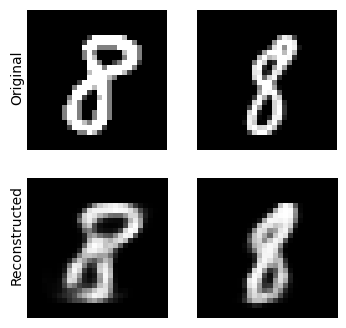

In [7]:
new_images = x_train[[245, 300]]

plot_images(rbm, new_images)